In [ ]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from torchvision.utils import save_image

import os
import numpy as np
from glob import glob
from imageio import imread
from skimage.transform import resize

## **Stage 1:** Data Preparation

In [ ]:
# YOUR CODE HERE for the transforming the dataset

data = glob('./PlantVillage/Noisy_Dataset/Train_Data/P*/*')
images = []
for i in range(len(data)):

    # Reading the data using imread
    img = imread(data[i])

    # Resize the images to 3 * 128 * 128 as the images are of different sizes
    img = resize(img,(16,16,3))

    # Appending all the images
    images.append(img)

# Converting the images into float32 array
images_arr = np.asarray(images)
images_arr = images_arr.astype('float32')
print("Dataset:", images_arr.shape)# The data has a shape of 320 x 224 x 224 since there are 320 samples each of the 224 x 224-dimensional matrix.

Dataset: (0,)


In [ ]:
image_height, image_width=128,128
transf=transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])

noise_train=datasets.ImageFolder('./PlantVillage/Noisy_Dataset/Train_Data/', transform=transf)
pure_train=datasets.ImageFolder('./PlantVillage/Pure_Dataset/Train_Data/', transform=transf)
noise_test=datasets.ImageFolder('./PlantVillage/Noisy_Dataset/Test_Data/', transform=transf)
pure_test=datasets.ImageFolder('./PlantVillage/Pure_Dataset/Test_Data/', transform=transf)

In [ ]:
pure_data = glob('./PlantVillage/Pure_Dataset/Train_Data/P*/*')
pure_images = []
for i in range(len(pure_data)):

    # Reading the data using imread
    pure_img = imread(pure_data[i])

    # Resize the images to 3 * 128 * 128 as the images are of different sizes
    pure_img = resize(pure_img,(128,128,3))

    # Appending all the images
    pure_images.append(pure_img)

# Converting the images into float32 array
images_pure = np.asarray(pure_images)
images_pure= images_pure.astype('float32')
print("Dataset:", images_pure.shape)# The data has a shape of 320 x 224 x 224 since there are 320 samples each of the 224 x 224-dimensional matrix.

<ipython-input-8-e7de7c01c87f>:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pure_img = imread(pure_data[i])


Dataset: (3007, 128, 128, 3)


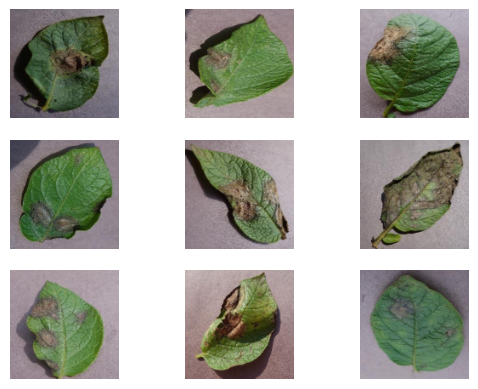

In [ ]:
for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.axis('off')
  plt.imshow(images_pure[i], cmap="gray")

In [ ]:
test_data = glob('./PlantVillage/Noisy_Dataset/Test_Data/P*/*')
images = []
for i in range(len(test_data)):

    # Reading the data using imread
    img = imread(test_data[i])

    # Resize the images to 3 * 128 * 128 as the images are of different sizes
    img = resize(img,(128,128,3))

    # Appending all the images
    images.append(img)

# Converting the images into float32 array
images_test = np.asarray(images)
images_test = images_test.astype('float32')
print("Dataset:", images_test.shape)# The data has a shape of 320 x 224 x 224 since there are 320 samples each of the 224 x 224-dimensional matrix.

<ipython-input-11-77936b762153>:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(test_data[i])


Dataset: (1613, 128, 128, 3)


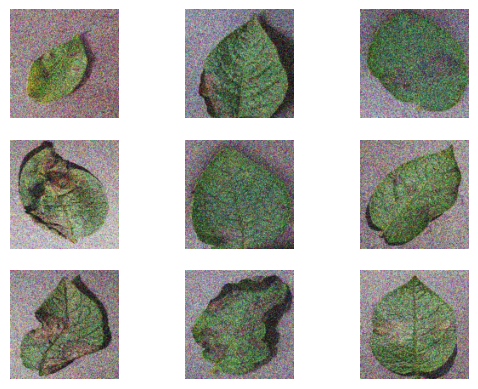

In [ ]:
for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.axis('off')
  plt.imshow(images_test[i], cmap="gray")

In [ ]:
test_data = glob('./PlantVillage/Pure_Dataset/Test_Data/P*/*')
images = []
for i in range(len(test_data)):

    # Reading the data using imread
    img = imread(test_data[i])

    # Resize the images to 3 * 128 * 128 as the images are of different sizes
    img = resize(img,(128,128,3))

    # Appending all the images
    images.append(img)

# Converting the images into float32 array
images_ground = np.asarray(images)
images_ground = images_ground.astype('float32')
print("Dataset:", images_ground.shape) # The data has a shape of 320 x 224 x 224 since there are 320 samples each of the 224 x 224-dimensional matrix.

<ipython-input-14-a23c6e16bf64>:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(test_data[i])


Dataset: (1613, 128, 128, 3)


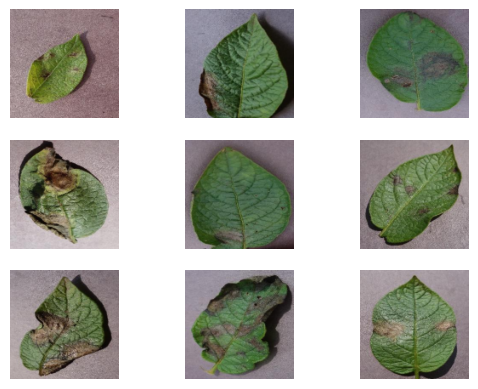

In [ ]:
for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.axis('off')
  plt.imshow(images_ground[i], cmap="gray")

In [ ]:
# YOUR CODE HERE for preparing trainloader and testloader set

# To convert numpy to tensor, load the data using tensordataset and convert the values to FloatTensor
#train_dataset = torch.utils.data.(torch.FloatTensor(images_arr))
#pure_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(images_pure))
#test_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(images_test),torch.FloatTensor(images_ground))

# Loading the train dataset aand test dataset
train_loader = torch.utils.data.DataLoader(noise_train, batch_size=64)
pure_loader = torch.utils.data.DataLoader(pure_train, batch_size=64)

test_loader = torch.utils.data.DataLoader(noise_test, batch_size=64)
ground_loader = torch.utils.data.DataLoader(pure_test, batch_size=64)

In [ ]:
image, label = next(iter(train_loader))

print(image.shape, label.shape)

torch.Size([64, 3, 128, 128]) torch.Size([64])


In [ ]:
# YOUR CODE HERE for constructing an autoencoder model

class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(300,100),
            nn.ReLU(),
            nn.Linear(100,30),
            nn.ReLU(),
            nn.Linear(30,30),
            nn.ReLU(),
            nn.Linear(30,2))
        self.decoder = nn.Sequential(
            nn.Linear(2,30),
            nn.ReLU(),
            nn.Linear(30,30),
            nn.ReLU(),
            nn.Linear(30,100),
            nn.ReLU(),
            nn.Linear(100,300))

    def forward(self, x):
        y = self.encoder(x)
        z = self.decoder(y)
        return y,z

In [ ]:
use_cuda = torch.cuda.is_available()
print('Using PyTorch version:', torch.__version__, 'CUDA:', use_cuda)

device  =  torch.device("cuda" if torch.cuda.is_available() else "cpu")

Using PyTorch version: 2.1.0+cu118 CUDA: True


In [ ]:
model = Autoencoder().to(device)

#summary(model,(1,224,224))

In [ ]:
# YOUR CODE HERE for declaring the loss function and optimizer

# Initialization of Mean Square Error
loss_func = nn.MSELoss()

# Initialization of Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

In [ ]:
# YOUR CODE HERE for defining a function for creating the directory
def make_dir():
    image_dir = './PlantVillage/Denoised_Images'
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)

def save_pic(img,name):
    img = img.view(3, 128, 128)
    save_image(img,name)

In [ ]:
# YOUR CODE HERE.

# Train the model and print the loss at each epoch. Also save the output (denoised) images in a directory.

make_dir()

EPOCH = 5
for epoch in range(EPOCH):

    for x, y in zip(train_loader, pure_loader):
        t_x, _ = x
        t_x = t_x.to(device)
        t_y, label = y
        t_y = t_y.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Passing the data to the model (Forward Pass)
        decoded1 = model(t_x)

        # Calculating mean square error loss
        loss = loss_func(decoded1, t_y)
        train_loss = loss.item()

        # Performing backward pass (Backpropagation)
        loss.backward()

        # optimizer.step() updates the weights accordingly
        optimizer.step()


    print('Epoch: ', epoch, '| train loss: %.4f' % train_loss)

Epoch:  0 | train loss: 0.0043
Epoch:  1 | train loss: 0.0033
Epoch:  2 | train loss: 0.0029
Epoch:  3 | train loss: 0.0027
Epoch:  4 | train loss: 0.0025


In [ ]:
# YOUR CODE HERE

# Record loss of the train denoised images

model.eval()
i=0
for x, y in zip(train_loader,pure_loader):
  i+=1
  # Convert the images and labels to gpu for faster execution
  t_x, _ = x
  eval_x = t_x.to(device)
  t_y, _ = y
  eval_y = t_y.to(device)
  # Passing the data to the model (Forward Pass)
  decoded2 = model(eval_x)
   # Calculating mean square error loss
  loss = loss_func(decoded2, eval_y)
  print(loss)
  for i in range(len(decoded2)):
    save_pic(decoded2[i].cpu().data,name='ae_{}.jpg'.format(i))

tensor(0.0030, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0031, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0030, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0030, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0033, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0030, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0030, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0032, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0031, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0029, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0030, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0030, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0030, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0029, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0029, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0028, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0031, device='cuda:0', grad_fn=

## **Stage 3:** Visualize the Denoised images

### 3 Marks -> Verify the denoised images and compare with original noisy images
1. Plot the original noisy images.
2. Plot denoised images which are saved in the directory.
3. Verify whether denoised images have less noise compared to original noisy images

**Hint:** If the noise is not reduced in the denoised images then revise the autoencoder architecture.

In [ ]:
# YOUR CODE HERE for plotting and verifying the images (original noisy images and denoising images)

for i in range(64):
  plt.subplot(8, 8, i+1)
  plt.axis('off')
  plt.imshow(images_arr[i], cmap="gray")

data = glob('./PlantVillage/Denoised_Images/ae_image578')

img = imread(data)

print(img.shape)

# Converting the images into float32 array
imag_denoised = np.asarray(img)
imag_denoised = images_arr.astype('float32')

plt.axis('off')
plt.imshow(imag_denoised, cmap="gray")



## **Stage 4:** Test the Model

In [ ]:
# YOUR CODE HERE for recording the loss of the test dataset

model.eval()
for x, y in zip(test_loader,ground_loader):
  # Convert the images and labels to gpu for faster execution
  t_x, _ = x
  eval_x = t_x.to(device)
  t_y, _ = y
  eval_y = t_y.to(device)
  # Passing the data to the model (Forward Pass)
  decoded2 = model(eval_x)
   # Calculating mean square error loss
  loss = loss_func(decoded2, eval_y)
  print(loss)
save_image(decoded2)

In [ ]:
# YOUR CODE HERE for verification and visualization of the test denoised images and original test noisy images
for i in range(64):
  plt.subplot(8, 8, i+1)
  plt.axis('off')
  plt.imshow(images_ground[i], cmap="gray")

data = glob('D:/Projects/Python/AIML-IIITH/MH-Autoencoder/PlantVillage/Denoised_Images/ae_image2')

plt.axis('off')
plt.imshow(data, cmap="gray")